/tmp/ipykernel_25588/1381870339.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


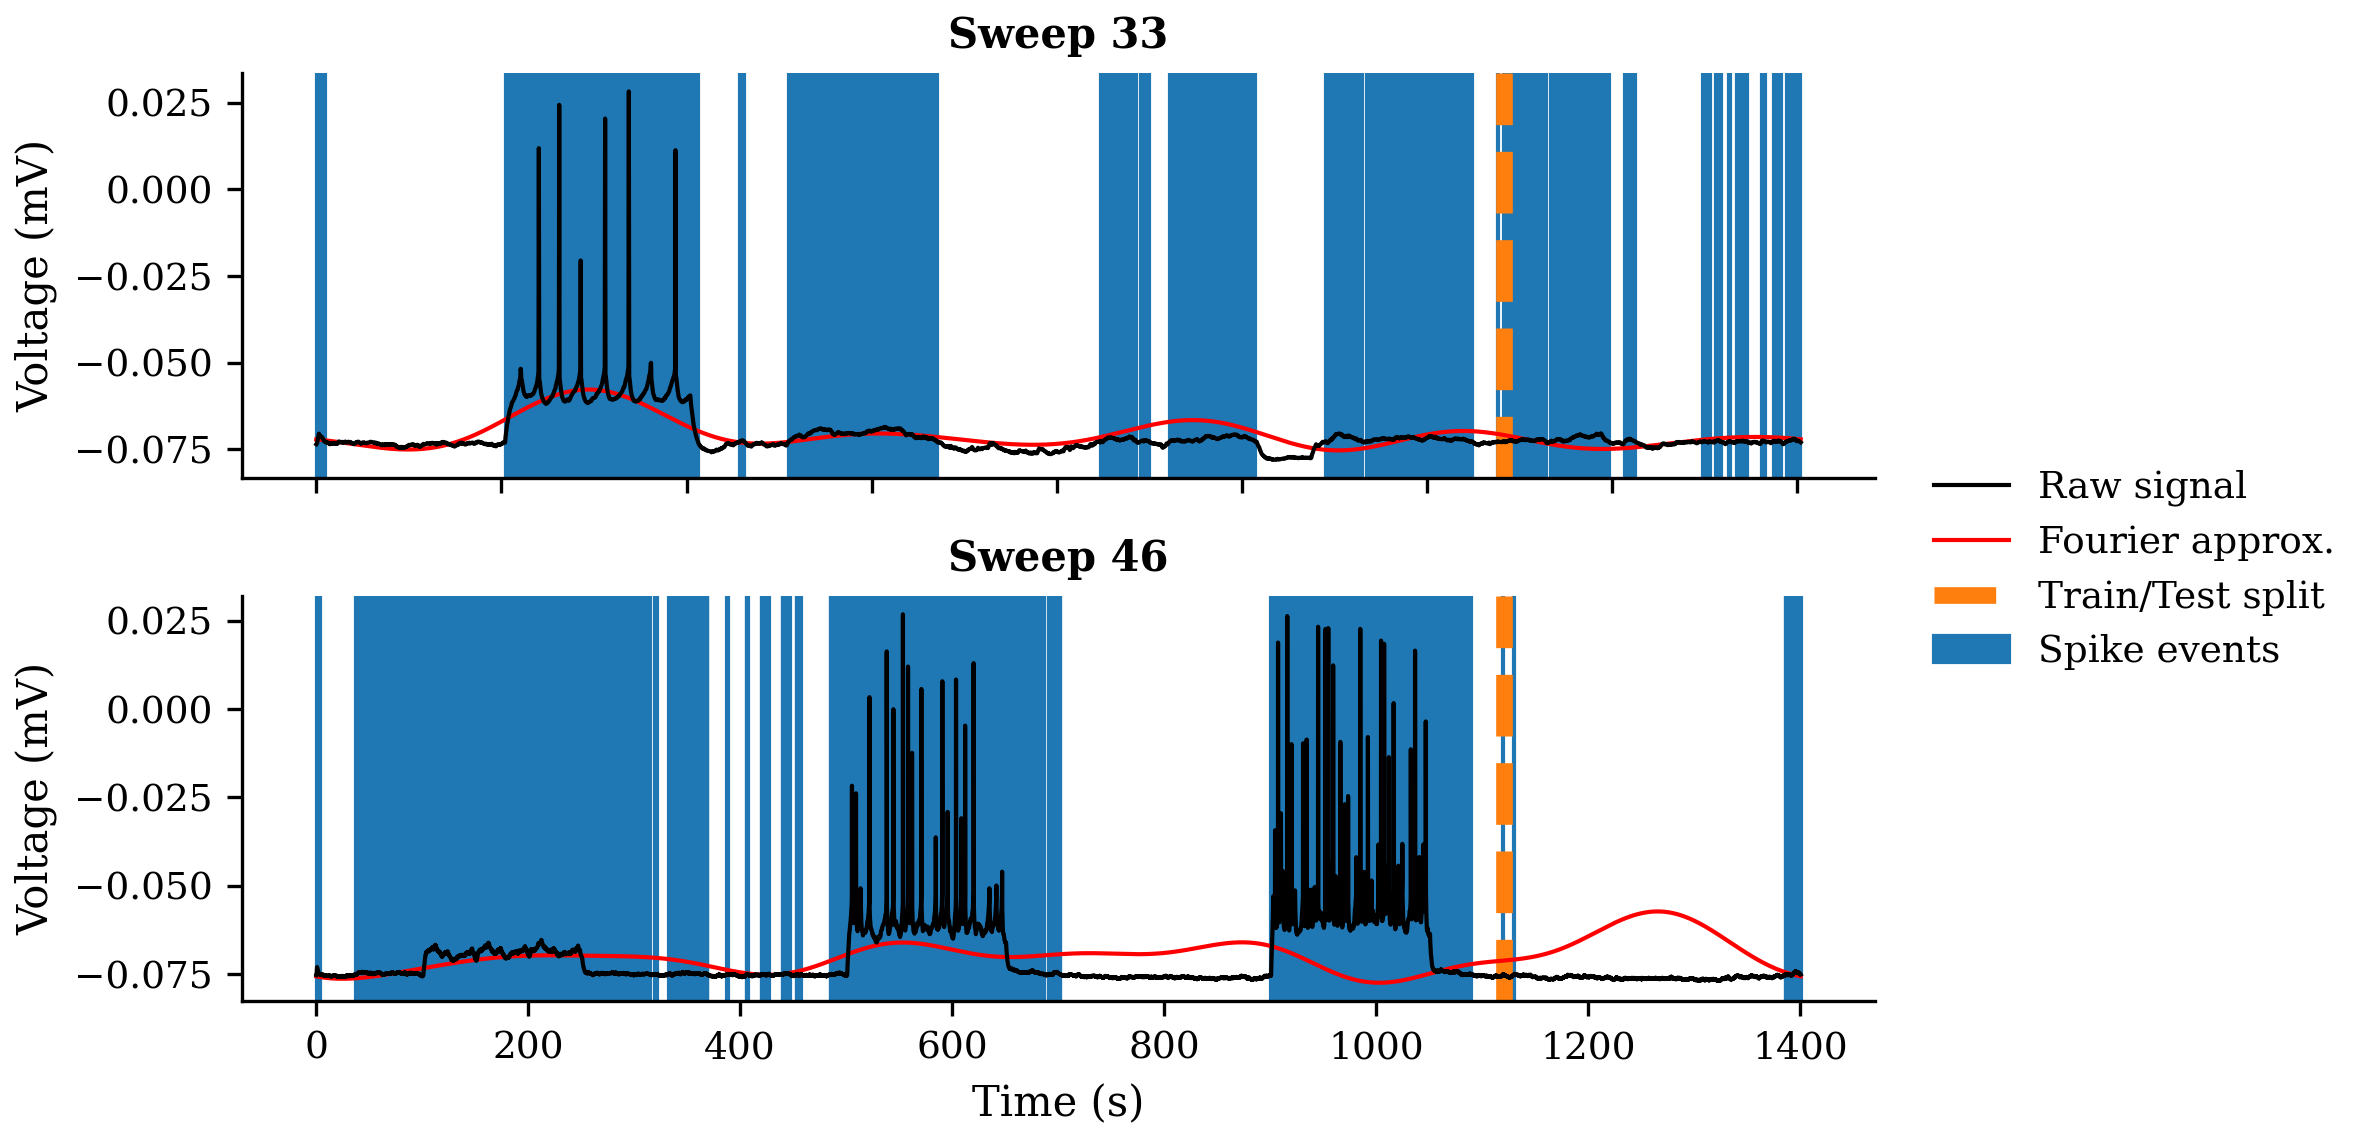

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import h5py
from manify.utils.dataloaders import load_hf
from scipy.fft import fft, ifft

data = h5py.File("../data/electrophysiology/623474383_ephys.nwb", "r")

plt.style.use("./icml.mplstyle")

X_33, _, _, y_33 = load_hf("neuron_33")
X_46, _, _, y_46 = load_hf("neuron_46")


def plot_indicator_ranges(ax, y, color="C0", alpha=1.0, downsample=100):
    """Plot background colors for contiguous ranges where y == 1"""
    y_down = y[::downsample]  # Downsample y for performance
    if len(y_down) == 0:
        return

    # Find where y changes from 0 to 1 or 1 to 0
    diff = np.diff(np.concatenate(([0], y_down, [0])))
    starts = np.where(diff == 1)[0] * downsample / 1000  # Convert to seconds
    ends = np.where(diff == -1)[0] * downsample / 1000    # Convert to seconds

    # Plot spans for each contiguous range
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, color=color, alpha=alpha)


fig, axs = plt.subplots(2, 1, figsize=(6.5, 4))
for ax, n, y in zip(axs, [33, 46], [y_33, y_46]):
    # Plot X
    X = np.array(data[f"acquisition/timeseries/Sweep_{n}/data"])

    # Take first 80% for training
    idx = int(0.8 * X.shape[0])
    X_train = X[:idx]

    # Get top 10 fourier components from training data
    X_train_fft = fft(X_train)
    top_10_idx = np.argsort(np.abs(X_train_fft))[::-1][:10]

    # Create approximation for full signal length
    X_full_fft = np.zeros(len(X), dtype=complex)

    # Scale the frequencies to match the full signal length
    for i in top_10_idx:
        freq_ratio = i / len(X_train)
        full_freq_idx = int(freq_ratio * len(X))
        if full_freq_idx < len(X):
            X_full_fft[full_freq_idx] = X_train_fft[i] * (len(X) / len(X_train))

    X_approx = ifft(X_full_fft).real

    # Plot indicator ranges (with consistent x-axis scaling)
    plot_indicator_ranges(ax, y)

    # Plot train/test split
    ax.axvline(idx / 1000, color="C1", linestyle="--", lw=4)

    # Plot the signals (x-axis in seconds)
    x_time = np.arange(0, len(X), 100) / 1000
    ax.plot(x_time, X_approx[::100], color="r")
    ax.plot(x_time, X[::100], color="k")

    # Formatting
    ax.set_title(f"Sweep {n}")

# Y labels
axs[0].set_ylabel("Voltage (mV)")
axs[1].set_ylabel("Voltage (mV)")

# X labels
axs[1].set_xlabel("Time (s)")
axs[0].set_xlabel("")
axs[0].set_xticklabels([])

# Create legend positioned to the right
legend_ax = fig.add_axes([1.1, 0.15, 0.02, 0.7])
legend_ax.axis("off")

# Create custom legend handles
handles = [
    mlines.Line2D([0], [0], color="k"),
    mlines.Line2D([0], [0], color="r"),
    mlines.Line2D([0], [0], color="C1", linestyle="--", lw=4),
    mpatches.Patch(color="C0")
]

labels = ["Raw signal", "Fourier approx.", "Train/Test split", "Spike events"]

legend_ax.legend(handles, labels, loc="center")

plt.tight_layout()
# plt.show()
plt.savefig("figures/electrophysiology.pdf", bbox_inches="tight")

In [3]:
x = load_hf("traffic")

In [7]:
import pandas as pd

pd.read_csv("/home/phil/manify/data/traffic/traffic.csv")["DateTime"].is_monotonic_increasing

False

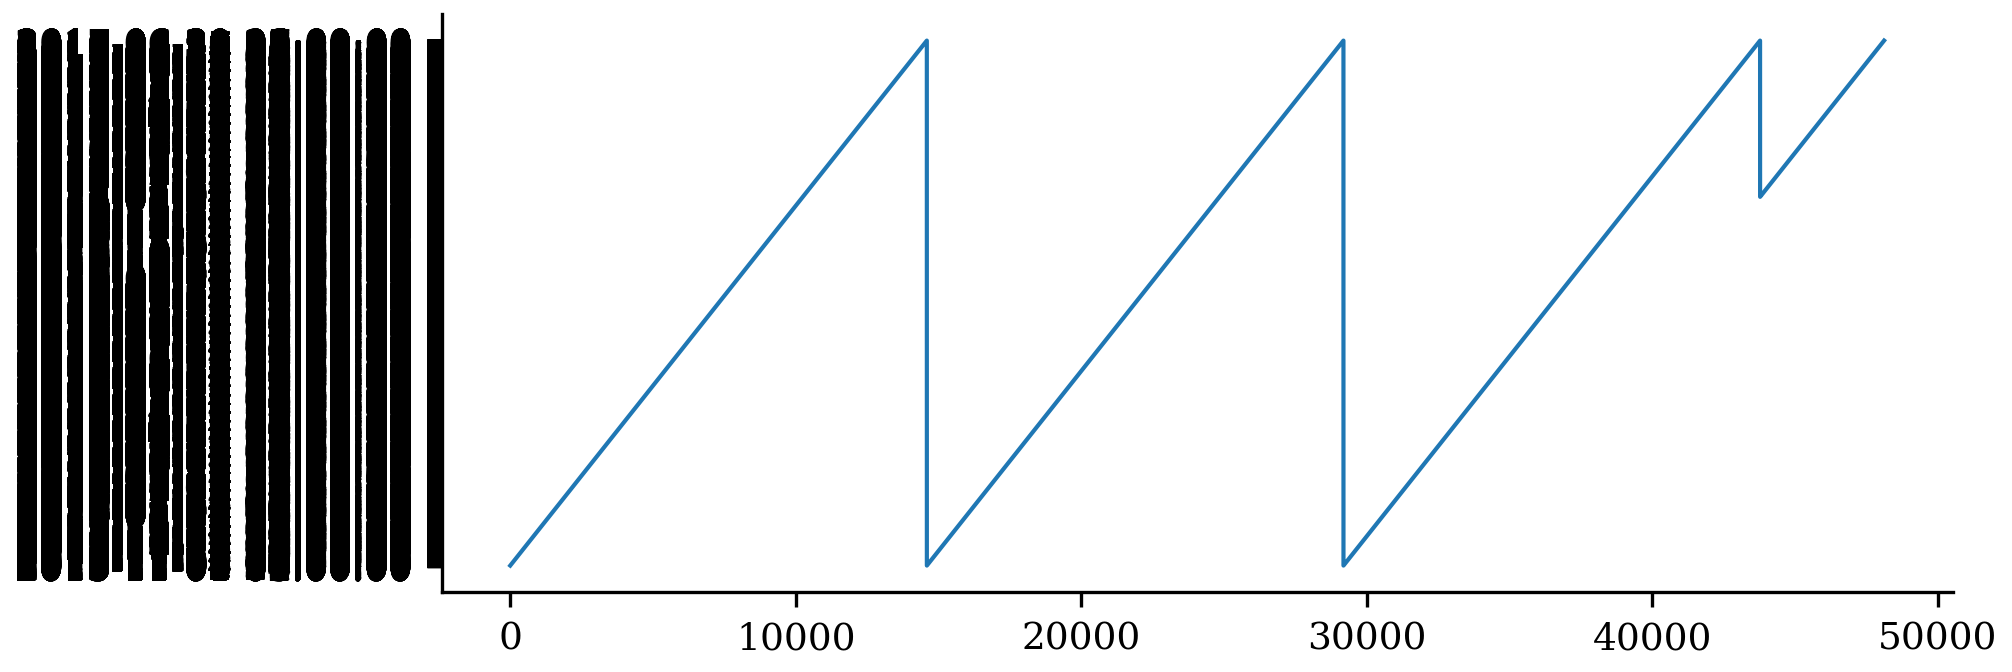

In [8]:
plt.plot(pd.read_csv("/home/phil/manify/data/traffic/traffic.csv")["DateTime"])